# Validating FiveThirtyEight's NBA Elo Implementation

This notebook loads data from `nba_elo.csv` which includes game data with both pre- and post- Elo ratings for each team.

The notebook uses the game data to compute the ratings and track them historically for each franchise.

Finally, the notebook compares and plots the Elo ratings computed vs FiveThirtyEight's published values.

## Setup

### Franchise Team Names

In [1]:
franchise_to_teams = {
    "ATL": ["TRI", "MLH", "STL", "ATL"],
    "BOS": ["BOS"],
    "BRK": ["NJA", "NYA", "NYN", "NJN", "BRK"],
    "CHO": ["CHH", "CHA", "CHO"],
    "CHI": ["CHI"],
    "CLE": ["CLE"],
    "DAL": ["DAL"],
    "DEN": ["DNR", "DNA", "DEN"],
    "DET": ["FTW", "DET"],
    "GSW": ["PHW", "SFW", "GSW"],
    "HOU": ["SDR", "HOU"],
    "IND": ["INA", "IND"],
    "LAC": ["BUF", "SDC", "LAC"],
    "LAL": ["MNL", "LAL"],
    "MEM": ["VAN", "MEM"],
    "MIA": ["MIA"],
    "MIL": ["MIL"],
    "MIN": ["MIN"],
    "NOP": ["NOH", "NOK", "NOP"],
    "NYK": ["NYK"],
    "OKC": ["SEA", "OKC"],
    "ORL": ["ORL"],
    "PHI": ["SYR", "PHI"],
    "PHO": ["PHO"],
    "POR": ["POR"],
    "SAC": ["ROC", "CIN", "KCO", "KCK", "SAC"],
    "SAS": ["DLC", "TEX", "SAA", "SAS"],
    "TOR": ["TOR"],
    "UTA": ["NOJ", "UTA"],
    "WAS": ["CHP", "CHZ", "BAL", "CAP", "WSB", "WAS"],
    "AND": ["AND"],
    "BLB": ["BLB"],
    "CHS": ["CHS"],
    "CLR": ["CLR"],
    "DNN": ["DNN"],
    "DTF": ["DTF"],
    "INJ": ["INJ"],
    "INO": ["INO"],
    "KEN": ["KEN"],
    "MMS": ["NOB", "MMP", "MMT", "MMS"],
    "PTC": ["PTP", "MNP", "PTC"],
    "PIT": ["PIT"],
    "PRO": ["PRO"],
    "SDS": ["SDA", "SDS"],
    "SHE": ["SHE"],
    "SSL": ["HSM", "CAR", "SSL"],
    "STB": ["STB"],
    "FLO": ["MNM", "MMF", "FLO"],
    "TRH": ["TRH"],
    "UTS": ["ANA", "LAS", "UTS"],
    "VIR": ["OAK", "WSA", "VIR"],
    "WSC": ["WSC"],
    "WAT": ["WAT"],
}

In [2]:
team_to_franchise = {}
for franchise, teams in franchise_to_teams.items():
    for team in teams:
        team_to_franchise[team] = franchise

### Elo Formula

In [3]:
R_0 = 1300.0

def R_next(K, S, E, R):
    return K * (S - E) + R

def K(MOV, R_diff):
    return 20 * (((MOV + 3) ** 0.8) / (7.5 + 0.006 * R_diff))

def S(did_win):
    return 1 if did_win else 0

def E(R_opp, R_team):
    return 1 / (1 + 10 ** ((R_opp - R_team) / 400)) 

## Validate Implementation

### Setup

In [4]:
import pandas as pd
from collections import defaultdict

In [5]:
df = pd.read_csv("nba_elo.csv")
ratings = defaultdict(lambda: R_0)
season = -1

In [6]:
def update_ratings(row):
    score_1 = row['score1']
    score_2 = row['score2']
    R_1 = row['elo1_pre']
    R_2 = row['elo2_pre']
    if not row['neutral']:
        R_1 += 100
    MOV = abs(score_1 - score_2)
    R_diff = R_1 - R_2 if score_1 > score_2 else R_2 - R_1
    k = K(MOV, R_diff)
    S_1 = S(score_1 > score_2)
    S_2 = S(score_2 > score_1)
    E_1 = E(R_2, R_1)
    E_2 = E(R_1, R_2)
    R_next1 = R_next(k, S_1, E_1, row['elo1_pre'])
    R_next2 = R_next(k, S_2, E_2, row['elo2_pre'])
    return R_next1, R_next2

def new_season(season):
    teams = set(df[df["season"] == season]["team1"])
    for team in teams:
        franchise = team_to_franchise[team]
        if ratings[franchise] == 1300.0:
            continue  # first season, do not regress rating to the mean
        ratings[franchise] = 0.75 * ratings[franchise] + 0.25 * 1505

def compute_valid_elos():
    season = [-1]  # Use a list to hold the season value so it can be modified
    def compute_row(row):
        if season[0] != row["season"]:
            season[0] = row["season"]
            new_season(season[0])
        franchise1 = team_to_franchise[row["team1"]]
        franchise2 = team_to_franchise[row["team2"]]
        row["valid_elo1_pre"] = ratings[franchise1]
        row["valid_elo2_pre"] = ratings[franchise2]
        R_next1, R_next2 = update_ratings(row)
        row["valid_elo1_post"] = R_next1
        row["valid_elo2_post"] = R_next2
        ratings[franchise1] = R_next1
        ratings[franchise2] = R_next2
        return row
    return compute_row

### Compute

In [7]:
df = df.apply(compute_valid_elos(), axis=1)

### Plot

In [8]:
import matplotlib.pyplot as plt

from scipy.stats import linregress

In [9]:
def plot_with_r2(ax, x, y, title):
    ax.scatter(df[x], df[y], alpha=0.5)
    ax.set_xlabel("FiveThirtyEight published")
    ax.set_ylabel("computed")
    ax.set_title(title)
    _, _, r, _, _ = linregress(df[x], df[y])
    ax.text(
        0.05,
        0.95,
        f"r² = {r**2:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
    )

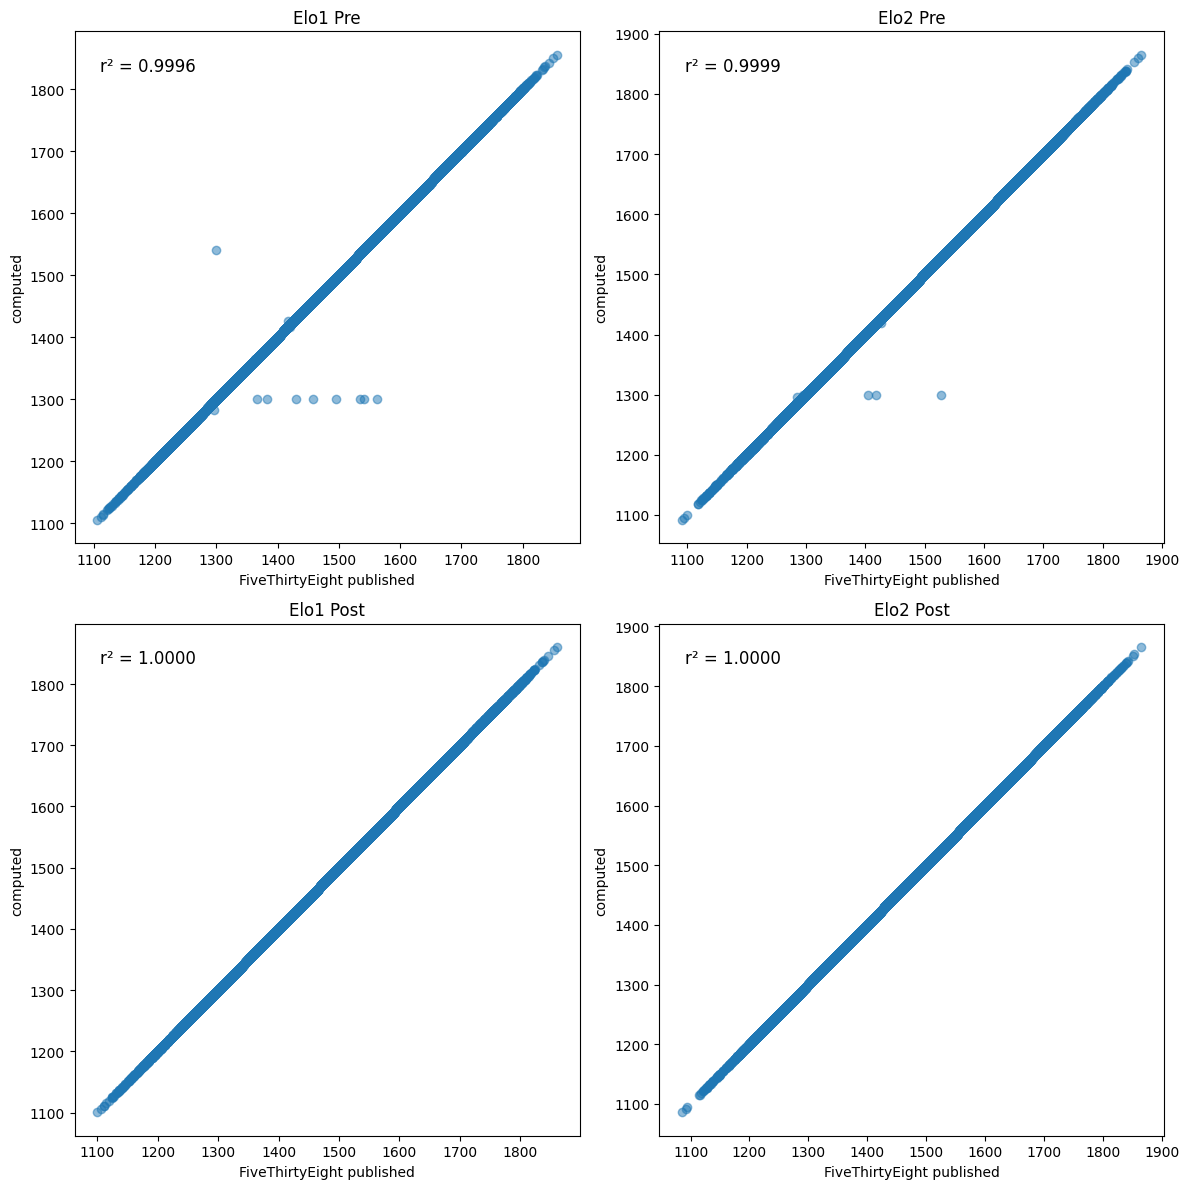

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_with_r2(axs[0, 0], "elo1_pre", "valid_elo1_pre", "Elo1 Pre")
plot_with_r2(axs[0, 1], "elo2_pre", "valid_elo2_pre", "Elo2 Pre")
plot_with_r2(axs[1, 0], "elo1_post", "valid_elo1_post", "Elo1 Post")
plot_with_r2(axs[1, 1], "elo2_post", "valid_elo2_post", "Elo2 Post")
plt.tight_layout()
plt.show()